In [1]:
import torch
import torch.nn as nn
import torch.fft
import numpy as np
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import matplotlib.pyplot as plt 

In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class FNO2D(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2D, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width

        self.fc0 = nn.Linear(3, self.width)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x = x.shape[2]
        size_y = x.shape[3]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = torch.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [4]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # Perform complex multiplication
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x = x.shape[2]
        size_y = x.shape[3]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x)

        # Apply spectral weights
        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(size_x, size_y))
        return x

In [60]:
image = Image.open("gs-img-01.png").convert("RGB")
low_res_transform = Resize((16, 16))
high_res_transform = Resize((1024, 1024))

In [67]:
def zero_pad_image(imge):
    if imge.shape != (16, 16, 3):
        raise ValueError("Input image must have shape (16, 16).")
    
    # Create a 32x32 array filled with zeros
    padded_imge = np.zeros((32, 32, 3), dtype=np.uint8)
    # Place the 16x16 image in the center
    padded_imge[8:24, 8:24, :] = imge
    return padded_imge

In [68]:
low_res_image = low_res_transform(image)
high_res_image = high_res_transform(image)

In [69]:
narr=np.array(low_res_image)
# narr=narr[:,:,0]
# narr.shape
low_res_image_pad=zero_pad_image(narr)
low_res_image_padimage = Image.fromarray(low_res_image_pad)
# low_res_image_padimage=low_res_image_padimage.unsqueeze(2)
low_res_image_padimage.size

(32, 32)

In [70]:
high_res_image.size

(1024, 1024)

In [71]:
low_res_tensor = ToTensor()(low_res_image_padimage).unsqueeze(0).to(torch.float32).to(device)
# low_res_tensor = ToTensor()(low_res_image).unsqueeze(0).to(torch.float32).to(device)
high_res_tensor = ToTensor()(high_res_image).unsqueeze(0).to(torch.float32).to(device)

In [72]:
low_res_tensor.shape, high_res_tensor.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 1024, 1024]))

In [81]:
modes = 16
width = 32
learning_rate = 0.001
epochs = 800

In [82]:
model = FNO2D(modes, modes, width).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(low_res_tensor.permute(0, 2, 3, 1))
    output_resized = Resize((1024, 1024))(output.permute(0, 3, 1, 2))
    loss = criterion(output_resized.squeeze(), high_res_tensor.squeeze())

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")

Epoch 0/800, Loss: 0.246230
Epoch 50/800, Loss: 0.006921
Epoch 100/800, Loss: 0.005659
Epoch 150/800, Loss: 0.005644
Epoch 200/800, Loss: 0.005643
Epoch 250/800, Loss: 0.005642
Epoch 300/800, Loss: 0.005642
Epoch 350/800, Loss: 0.005642
Epoch 400/800, Loss: 0.005642
Epoch 450/800, Loss: 0.005642
Epoch 500/800, Loss: 0.005642
Epoch 550/800, Loss: 0.005642
Epoch 600/800, Loss: 0.005642
Epoch 650/800, Loss: 0.005642
Epoch 700/800, Loss: 0.005642
Epoch 750/800, Loss: 0.005642


In [84]:
model.eval()
with torch.no_grad():
    predicted_high_res = model(low_res_tensor.permute(0, 2, 3, 1))
    predicted_high_res01 = Resize((1024, 1024))(predicted_high_res.permute(0, 3, 1, 2)).squeeze(0)

In [77]:
# predicted_high_res01=predicted_high_res.permute(0, 3, 1, 2).squeeze(0)
predicted_high_res01.shape

torch.Size([1, 1024, 1024])

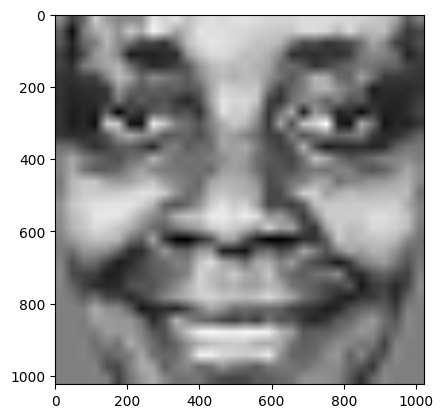

In [95]:
plt.imshow(predicted_high_res01.permute(1, 2, 0).cpu().numpy(), cmap="gray")

In [86]:
ppr=predicted_high_res01.permute(1, 2, 0).cpu().numpy()
ppr.shape

(1024, 1024, 1)

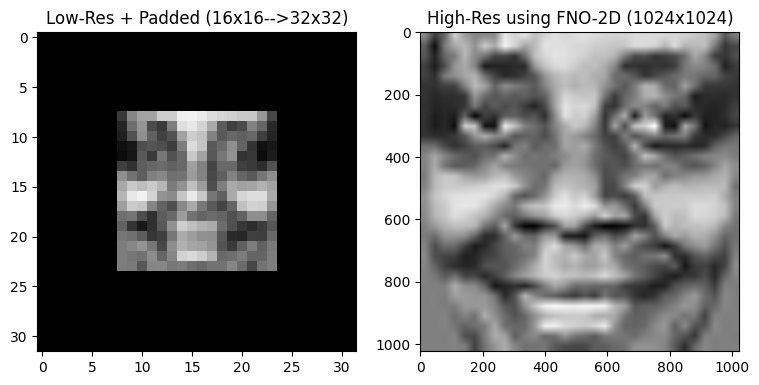

In [94]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.title("Low-Res + Padded (16x16-->32x32)")
plt.imshow(low_res_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap="gray")
# plt.subplot(1, 3, 3)
# plt.title("lo-to-hi resize Image")
# plt.imshow(high_res_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title("High-Res using FNO-2D (1024x1024)")
# fnl_img=predicted_high_res01.permute(1, 2, 0).cpu().numpy()
# fnl_img = Image.fromarray((fnl_img * 255).astype(np.uint8))
# fnl001=fnl_img.convert("RGB")

plt.imshow(ppr,cmap="gray")

plt.show()

In [88]:
lrt=low_res_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
lrt=lrt[:,:,0]
ppr=ppr.squeeze(2)
ppr.shape, lrt.shape

((1024, 1024), (32, 32))

In [89]:
def plot_3d_representation(image):
    height, width = image.shape
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    z = image

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    ax.set_title("3D Representation of Image")
    ax.set_xlabel("X (Width)")
    ax.set_ylabel("Y (Height)")
    ax.set_zlabel("Pixel Value")

    plt.show()

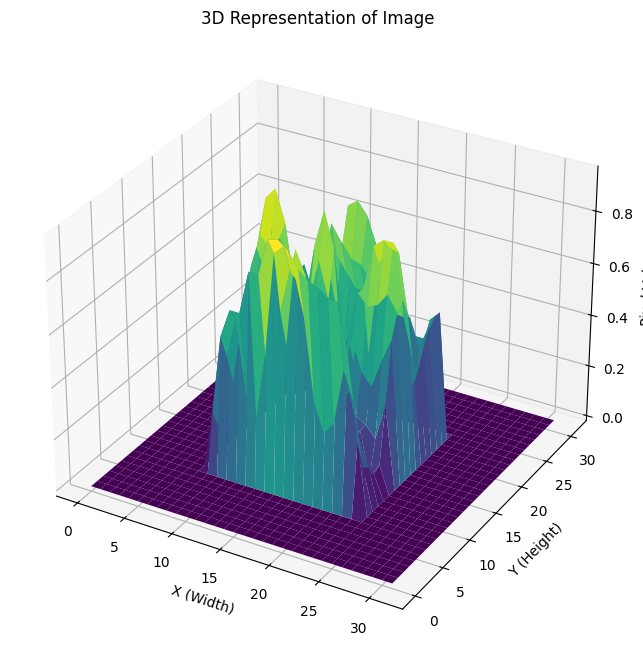

In [90]:
# initial image 64x64
plot_3d_representation(lrt)

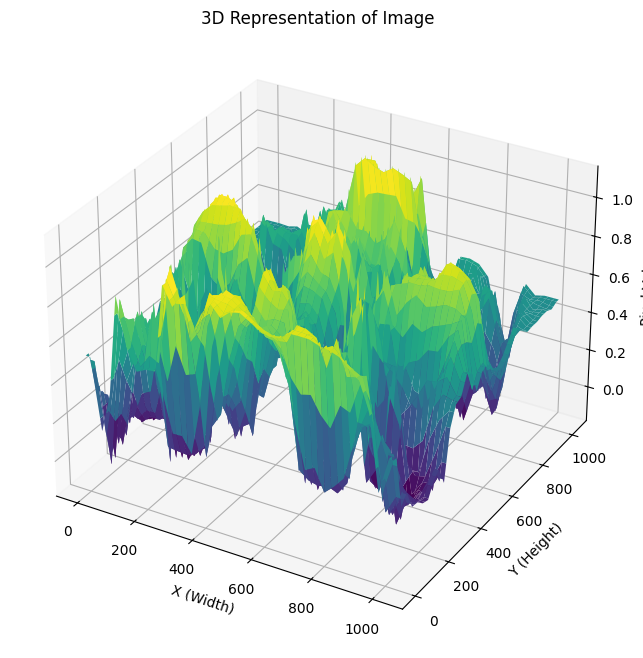

In [91]:
# Final Image 1024x1024
plot_3d_representation(ppr)